# COSMOS master catalogue for Farmer photometry
## Convert COSMOS2020 to help format for HELP DR2 alpha

This catalogue comes from `dmu1_COSMOS2020`. We here process the COSMOS2020 catalogue to the HELP format so that it can be merged in with the full area HELP cosmos data sets.



In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))
import datetime
print("This notebook was executed on: \n{}".format(datetime.datetime.now()))

This notebook was run with herschelhelp_internal version: 
1407877 (Mon Feb 4 12:56:29 2019 +0000)
This notebook was executed on: 
2021-01-20 19:00:57.228387


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

from collections import OrderedDict
import os

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np

from herschelhelp_internal.flagging import  gaia_flag_column
from herschelhelp_internal.masterlist import nb_astcor_diag_plot, remove_duplicates
from herschelhelp_internal.utils import astrometric_correction, mag_to_flux, flux_to_mag

/Users/rs548/miniconda3/envs/herschelhelp_internal/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/Users/rs548/miniconda3/envs/herschelhelp_internal/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/rs548/miniconda3/envs/herschelhelp_internal/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/Users/rs548/miniconda3/envs/herschelhelp_internal/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  sel

In [3]:
OUT_DIR =  os.environ.get('TMP_DIR', "./data_tmp")
#OUT_DIR = '/Volumes/Raph500/COSMOS2020'
OUT_DIR = '/home/rshirley/COSMOS2020'
try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

RA_COL = "cosmos_ra"
DEC_COL = "cosmos_dec"

## I - Column selection

In [4]:
bands = OrderedDict({
    'UVISTA_Ks': 'vista_ks',
    'UVISTA_Y': 'vista_y',
    'UVISTA_H': 'vista_h',
    'UVISTA_J': 'vista_j',

    #CFHT Megacam
    'CFHT_u': 'megacam_u',
    #SUBARU Suprime
    #'SC_B': 'suprime_b',
    #'SC_V': 'suprime_v',
    #'SC_ip': 'suprime_ip',
    #'SC_rp': 'suprime_rc',
    #'SC_zp': 'suprime_zp',
    #'SC_zpp': 'suprime_zpp',
    'SC_IA484': 'suprime_ia484',
    'SC_IA527': 'suprime_ia527',
    'SC_IA624': 'suprime_ia624',
    'SC_IA679': 'suprime_ia679',
    'SC_IA738': 'suprime_ia738',
    'SC_IA767': 'suprime_ia767',
    'SC_IB427': 'suprime_ib427',
    'SC_IB464': 'suprime_ib464',
    'SC_IB505': 'suprime_ib505',
    'SC_IB574': 'suprime_ib574',
    'SC_IB709': 'suprime_ib709',
    'SC_IB827': 'suprime_ib827',
    'SC_NB711': 'suprime_nb711',
    'SC_NB816': 'suprime_nb816',
    #CFHT WIRCAM
    #'hw': 'wircam_h',
    #'ksw': 'wircam_ks',
    #SUBARU HSC
    'HSC_g': 'suprime_g',
    'HSC_r': 'suprime_r',
    'HSC_i': 'suprime_i',
    'HSC_z': 'suprime_z',
    'HSC_y': 'suprime_y',
    #Spitzer IRAC
    'IRAC_1': 'irac_i1', #'irac_i1'???
    'IRAC_2': 'irac_i2', # #irac_i2
    'SPLASH_3': 'irac_i3', # #irac_i1
    'SPLASH_4': 'irac_i4', # #irac_i4
})

In [5]:
imported_columns = OrderedDict({
    #'help_id': 'help_id', #COSMOS 2020 hasn't had help ids added
    'ID': 'cosmos_id',
    'ALPHA_J2000': 'cosmos_ra',
    'DELTA_J2000': 'cosmos_dec',
    #'class': 'cosmos_stellarity', #No stellarity in COSMOS 2020?
})

for band in bands:
  
    imported_columns.update({band + '_MAG': 'm_cosmos-' + bands[band]})
    imported_columns.update({band + '_MAGERR': 'merr_cosmos-' + bands[band]})
    imported_columns.update({band + '_FLUX': 'f_cosmos-' + bands[band]})
    imported_columns.update({band + '_FLUXERR': 'ferr_cosmos-' + bands[band]})
    if 'SPLASH' not in band:
        imported_columns.update({band + '_CHISQ': 'chisq_cosmos-' + bands[band]})
      
        


In [6]:

catalogue = Table.read(
    OUT_DIR+"/cosmos2020.calet.org/PHOTOMETRY"
    +"/COSMOS2020_FARMER_v1.8_formatted.fits")[list(imported_columns)]
for column in imported_columns:
    catalogue[column].name = imported_columns[column]

epoch = 2015 #Various epochs

# Clean table metadata
catalogue.meta = None

In [7]:
# Adding flux and band-flag columns
for col in catalogue.colnames:
    #print(col)

    if col.startswith('m_'):
        
        errcol = "merr{}".format(col[1:])
        chisqcol = "chisq{}".format(col[1:])
        
        mask = (catalogue[col] > 90.) | (catalogue[col] < 0.)
        catalogue[col][mask] = np.nan
        catalogue[errcol][mask]  = np.nan     
        
  
        if ('irac_i3' not in col) and ('irac_i4' not in col):
            # Band-flag column
            catalogue.add_column(Column(catalogue[chisqcol]>5, name="flag{}".format(col[1:]), dtype=bool))
            catalogue.remove_column(chisqcol)
    if col.startswith('f_'):
        errcol = "ferr{}".format(col[1:])
        
        mask = (np.isclose(catalogue[col] , -99.) )
        catalogue[col][mask] = np.nan
        catalogue[errcol][mask] = np.nan 
        
  


In [8]:
catalogue[:10].show_in_notebook()

idx,cosmos_id,cosmos_ra,cosmos_dec,m_cosmos-vista_ks,merr_cosmos-vista_ks,f_cosmos-vista_ks,ferr_cosmos-vista_ks,m_cosmos-vista_y,merr_cosmos-vista_y,f_cosmos-vista_y,ferr_cosmos-vista_y,m_cosmos-vista_h,merr_cosmos-vista_h,f_cosmos-vista_h,ferr_cosmos-vista_h,m_cosmos-vista_j,merr_cosmos-vista_j,f_cosmos-vista_j,ferr_cosmos-vista_j,m_cosmos-megacam_u,merr_cosmos-megacam_u,f_cosmos-megacam_u,ferr_cosmos-megacam_u,m_cosmos-suprime_ia484,merr_cosmos-suprime_ia484,f_cosmos-suprime_ia484,ferr_cosmos-suprime_ia484,m_cosmos-suprime_ia527,merr_cosmos-suprime_ia527,f_cosmos-suprime_ia527,ferr_cosmos-suprime_ia527,m_cosmos-suprime_ia624,merr_cosmos-suprime_ia624,f_cosmos-suprime_ia624,ferr_cosmos-suprime_ia624,m_cosmos-suprime_ia679,merr_cosmos-suprime_ia679,f_cosmos-suprime_ia679,ferr_cosmos-suprime_ia679,m_cosmos-suprime_ia738,merr_cosmos-suprime_ia738,f_cosmos-suprime_ia738,ferr_cosmos-suprime_ia738,m_cosmos-suprime_ia767,merr_cosmos-suprime_ia767,f_cosmos-suprime_ia767,ferr_cosmos-suprime_ia767,m_cosmos-suprime_ib427,merr_cosmos-suprime_ib427,f_cosmos-suprime_ib427,ferr_cosmos-suprime_ib427,m_cosmos-suprime_ib464,merr_cosmos-suprime_ib464,f_cosmos-suprime_ib464,ferr_cosmos-suprime_ib464,m_cosmos-suprime_ib505,merr_cosmos-suprime_ib505,f_cosmos-suprime_ib505,ferr_cosmos-suprime_ib505,m_cosmos-suprime_ib574,merr_cosmos-suprime_ib574,f_cosmos-suprime_ib574,ferr_cosmos-suprime_ib574,m_cosmos-suprime_ib709,merr_cosmos-suprime_ib709,f_cosmos-suprime_ib709,ferr_cosmos-suprime_ib709,m_cosmos-suprime_ib827,merr_cosmos-suprime_ib827,f_cosmos-suprime_ib827,ferr_cosmos-suprime_ib827,m_cosmos-suprime_nb711,merr_cosmos-suprime_nb711,f_cosmos-suprime_nb711,ferr_cosmos-suprime_nb711,m_cosmos-suprime_nb816,merr_cosmos-suprime_nb816,f_cosmos-suprime_nb816,ferr_cosmos-suprime_nb816,m_cosmos-suprime_g,merr_cosmos-suprime_g,f_cosmos-suprime_g,ferr_cosmos-suprime_g,m_cosmos-suprime_r,merr_cosmos-suprime_r,f_cosmos-suprime_r,ferr_cosmos-suprime_r,m_cosmos-suprime_i,merr_cosmos-suprime_i,f_cosmos-suprime_i,ferr_cosmos-suprime_i,m_cosmos-suprime_z,merr_cosmos-suprime_z,f_cosmos-suprime_z,ferr_cosmos-suprime_z,m_cosmos-suprime_y,merr_cosmos-suprime_y,f_cosmos-suprime_y,ferr_cosmos-suprime_y,m_cosmos-irac_i1,merr_cosmos-irac_i1,f_cosmos-irac_i1,ferr_cosmos-irac_i1,m_cosmos-irac_i2,merr_cosmos-irac_i2,f_cosmos-irac_i2,ferr_cosmos-irac_i2,m_cosmos-irac_i3,merr_cosmos-irac_i3,f_cosmos-irac_i3,ferr_cosmos-irac_i3,m_cosmos-irac_i4,merr_cosmos-irac_i4,f_cosmos-irac_i4,ferr_cosmos-irac_i4,flag_cosmos-vista_ks,flag_cosmos-vista_y,flag_cosmos-vista_h,flag_cosmos-vista_j,flag_cosmos-megacam_u,flag_cosmos-suprime_ia484,flag_cosmos-suprime_ia527,flag_cosmos-suprime_ia624,flag_cosmos-suprime_ia679,flag_cosmos-suprime_ia738,flag_cosmos-suprime_ia767,flag_cosmos-suprime_ib427,flag_cosmos-suprime_ib464,flag_cosmos-suprime_ib505,flag_cosmos-suprime_ib574,flag_cosmos-suprime_ib709,flag_cosmos-suprime_ib827,flag_cosmos-suprime_nb711,flag_cosmos-suprime_nb816,flag_cosmos-suprime_g,flag_cosmos-suprime_r,flag_cosmos-suprime_i,flag_cosmos-suprime_z,flag_cosmos-suprime_y,flag_cosmos-irac_i1,flag_cosmos-irac_i2
,,deg,deg,mag,uJy,uJy,uJy,mag,uJy,uJy,uJy,mag,uJy,uJy,uJy,mag,uJy,uJy,uJy,mag,uJy,uJy,uJy,mag,uJy,uJy,uJy,mag,uJy,uJy,uJy,mag,uJy,uJy,uJy,mag,uJy,uJy,uJy,mag,uJy,uJy,uJy,mag,uJy,uJy,uJy,mag,uJy,uJy,uJy,mag,uJy,uJy,uJy,mag,uJy,uJy,uJy,mag,uJy,uJy,uJy,mag,uJy,uJy,uJy,mag,uJy,uJy,uJy,mag,uJy,uJy,uJy,mag,uJy,uJy,uJy,mag,uJy,uJy,uJy,mag,uJy,uJy,uJy,mag,uJy,uJy,uJy,mag,uJy,uJy,uJy,mag,uJy,uJy,uJy,mag,uJy,uJy,uJy,mag,uJy,uJy,uJy,mag,mag,uJy,uJy,mag,mag,uJy,uJy,,,,,,,,,,,,,,,,,,,,,,,,,,
0,234,149.73173343147582,1.9589006053706217,23.388622496706716,0.012925624763478522,1.601588719668913,0.01918076458037521,23.275052210012046,0.005558381458812394,1.778193899620512,0.009126731930581706,23.067368508317188,0.006465100951915382,2.1530424702821547,0.01285870548090382,23.129606137809578,0.005397657045255633,2.0330944034881857,0.010132543819226814,28.19112291338303,0.19903160983302187,0.0192

## II - Removal of duplicated sources

We remove duplicated objects from the input catalogues.

In [11]:
SORT_COLS = []
for f in bands:
    if 'irac' not in bands[f]:
        SORT_COLS += ['merr_cosmos-' + bands[f]]


In [12]:
#SORT_COLS = ['merr_ap_gpc1_r', 'merr_ap_gpc1_g', 'merr_ap_gpc1_i', 'merr_ap_gpc1_z', 'merr_ap_gpc1_y']
FLAG_NAME = 'cosmos_flag_cleaned'

nb_orig_sources = len(catalogue)

catalogue = remove_duplicates(catalogue, RA_COL, DEC_COL,  sort_col=SORT_COLS, flag_name=FLAG_NAME)

nb_sources = len(catalogue)

print("The initial catalogue had {} sources.".format(nb_orig_sources))
print("The cleaned catalogue has {} sources ({} removed).".format(nb_sources, nb_orig_sources - nb_sources))
print("The cleaned catalogue has {} sources flagged as having been cleaned".format(np.sum(catalogue[FLAG_NAME])))

The initial catalogue had 93714 sources.
The cleaned catalogue has 93629 sources (85 removed).
The cleaned catalogue has 82 sources flagged as having been cleaned


## III - Astrometry correction

We match the astrometry to the Gaia one. We limit the Gaia catalogue to sources with a g band flux between the 30th and the 70th percentile. Some quick tests show that this give the lower dispersion in the results.

In [13]:
gaia = Table.read("../../dmu0/dmu0_GAIA/data/GAIA_COSMOS.fits")
gaia_coords = SkyCoord(gaia['ra'], gaia['dec'])

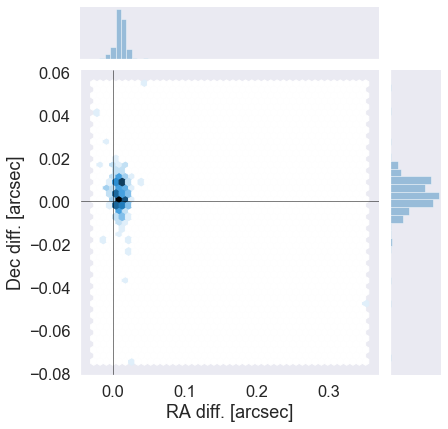

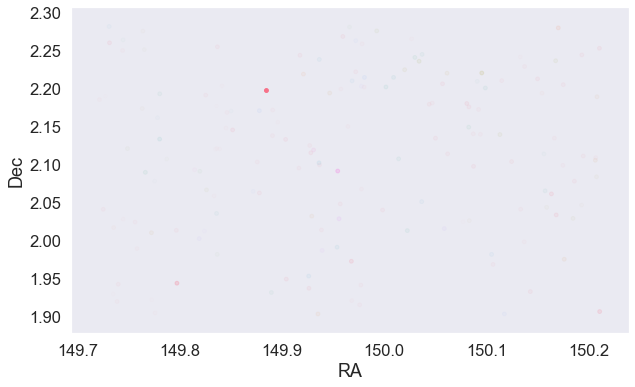

In [14]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

In [15]:
delta_ra, delta_dec =  astrometric_correction(
    SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]),
    gaia_coords
)

print("RA correction: {}".format(delta_ra))
print("Dec correction: {}".format(delta_dec))

RA correction: -0.009482226306545272 arcsec
Dec correction: -0.002729276520785362 arcsec


In [16]:
delta_ra.to(u.deg).value

-2.633951751818131e-06

In [17]:
catalogue[RA_COL] +=  delta_ra.to(u.deg).value
catalogue[DEC_COL] += delta_dec.to(u.deg).value

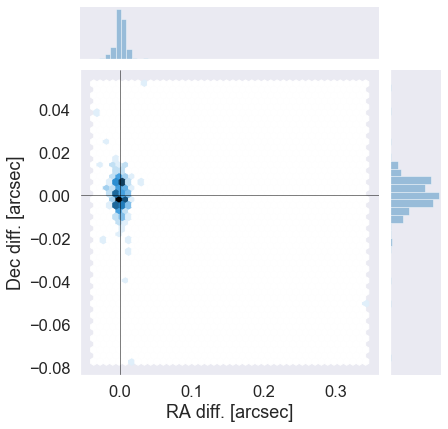

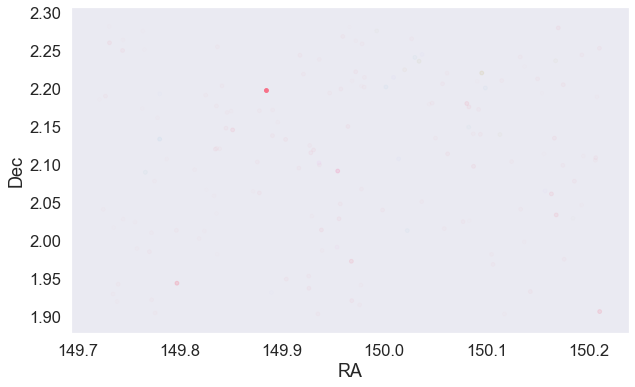

In [18]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

## IV - Flagging Gaia objects

In [19]:
catalogue.add_column(
    gaia_flag_column(SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]), epoch, gaia)
)

In [20]:
GAIA_FLAG_NAME = "cosmos_flag_gaia"

catalogue['flag_gaia'].name = GAIA_FLAG_NAME
print("{} sources flagged.".format(np.sum(catalogue[GAIA_FLAG_NAME] > 0)))

164 sources flagged.


# VI - Saving to disk

In [21]:
catalogue[:5]

cosmos_id,cosmos_ra,cosmos_dec,m_cosmos-vista_ks,merr_cosmos-vista_ks,f_cosmos-vista_ks,ferr_cosmos-vista_ks,m_cosmos-vista_y,merr_cosmos-vista_y,f_cosmos-vista_y,ferr_cosmos-vista_y,m_cosmos-vista_h,merr_cosmos-vista_h,f_cosmos-vista_h,ferr_cosmos-vista_h,m_cosmos-vista_j,merr_cosmos-vista_j,f_cosmos-vista_j,ferr_cosmos-vista_j,m_cosmos-megacam_u,merr_cosmos-megacam_u,f_cosmos-megacam_u,ferr_cosmos-megacam_u,m_cosmos-suprime_ia484,merr_cosmos-suprime_ia484,f_cosmos-suprime_ia484,ferr_cosmos-suprime_ia484,m_cosmos-suprime_ia527,merr_cosmos-suprime_ia527,f_cosmos-suprime_ia527,ferr_cosmos-suprime_ia527,m_cosmos-suprime_ia624,merr_cosmos-suprime_ia624,f_cosmos-suprime_ia624,ferr_cosmos-suprime_ia624,m_cosmos-suprime_ia679,merr_cosmos-suprime_ia679,f_cosmos-suprime_ia679,ferr_cosmos-suprime_ia679,m_cosmos-suprime_ia738,merr_cosmos-suprime_ia738,f_cosmos-suprime_ia738,ferr_cosmos-suprime_ia738,m_cosmos-suprime_ia767,merr_cosmos-suprime_ia767,f_cosmos-suprime_ia767,ferr_cosmos-suprime_ia767,m_cosmos-suprime_ib427,merr_cosmos-suprime_ib427,f_cosmos-suprime_ib427,ferr_cosmos-suprime_ib427,m_cosmos-suprime_ib464,merr_cosmos-suprime_ib464,f_cosmos-suprime_ib464,ferr_cosmos-suprime_ib464,m_cosmos-suprime_ib505,merr_cosmos-suprime_ib505,f_cosmos-suprime_ib505,ferr_cosmos-suprime_ib505,m_cosmos-suprime_ib574,merr_cosmos-suprime_ib574,f_cosmos-suprime_ib574,ferr_cosmos-suprime_ib574,m_cosmos-suprime_ib709,merr_cosmos-suprime_ib709,f_cosmos-suprime_ib709,ferr_cosmos-suprime_ib709,m_cosmos-suprime_ib827,merr_cosmos-suprime_ib827,f_cosmos-suprime_ib827,ferr_cosmos-suprime_ib827,m_cosmos-suprime_nb711,merr_cosmos-suprime_nb711,f_cosmos-suprime_nb711,ferr_cosmos-suprime_nb711,m_cosmos-suprime_nb816,merr_cosmos-suprime_nb816,f_cosmos-suprime_nb816,ferr_cosmos-suprime_nb816,m_cosmos-suprime_g,merr_cosmos-suprime_g,f_cosmos-suprime_g,ferr_cosmos-suprime_g,m_cosmos-suprime_r,merr_cosmos-suprime_r,f_cosmos-suprime_r,ferr_cosmos-suprime_r,m_cosmos-suprime_i,merr_cosmos-suprime_i,f_cosmos-suprime_i,ferr_cosmos-suprime_i,m_cosmos-suprime_z,merr_cosmos-suprime_z,f_cosmos-suprime_z,ferr_cosmos-suprime_z,m_cosmos-suprime_y,merr_cosmos-suprime_y,f_cosmos-suprime_y,ferr_cosmos-suprime_y,m_cosmos-irac_i1,merr_cosmos-irac_i1,f_cosmos-irac_i1,ferr_cosmos-irac_i1,m_cosmos-irac_i2,merr_cosmos-irac_i2,f_cosmos-irac_i2,ferr_cosmos-irac_i2,m_cosmos-irac_i3,merr_cosmos-irac_i3,f_cosmos-irac_i3,ferr_cosmos-irac_i3,m_cosmos-irac_i4,merr_cosmos-irac_i4,f_cosmos-irac_i4,ferr_cosmos-irac_i4,flag_cosmos-vista_ks,flag_cosmos-vista_y,flag_cosmos-vista_h,flag_cosmos-vista_j,flag_cosmos-megacam_u,flag_cosmos-suprime_ia484,flag_cosmos-suprime_ia527,flag_cosmos-suprime_ia624,flag_cosmos-suprime_ia679,flag_cosmos-suprime_ia738,flag_cosmos-suprime_ia767,flag_cosmos-suprime_ib427,flag_cosmos-suprime_ib464,flag_cosmos-suprime_ib505,flag_cosmos-suprime_ib574,flag_cosmos-suprime_ib709,flag_cosmos-suprime_ib827,flag_cosmos-suprime_nb711,flag_cosmos-suprime_nb816,flag_cosmos-suprime_g,flag_cosmos-suprime_r,flag_cosmos-suprime_i,flag_cosmos-suprime_z,flag_cosmos-suprime_y,flag_cosmos-irac_i1,flag_cosmos-irac_i2,cosmos_flag_cleaned,cosmos_flag_gaia
,deg,deg,mag,uJy,uJy,uJy,mag,uJy,uJy,uJy,mag,uJy,uJy,uJy,mag,uJy,uJy,uJy,mag,uJy,uJy,uJy,mag,uJy,uJy,uJy,mag,uJy,uJy,uJy,mag,uJy,uJy,uJy,mag,uJy,uJy,uJy,mag,uJy,uJy,uJy,mag,uJy,uJy,uJy,mag,uJy,uJy,uJy,mag,uJy,uJy,uJy,mag,uJy,uJy,uJy,mag,uJy,uJy,uJy,mag,uJy,uJy,uJy,mag,uJy,uJy,uJy,mag,uJy,uJy,uJy,mag,uJy,uJy,uJy,mag,uJy,uJy,uJy,mag,uJy,uJy,uJy,mag,uJy,uJy,uJy,mag,uJy,uJy,uJy,mag,uJy,uJy,uJy,mag,uJy,uJy,uJy,mag,uJy,uJy,uJy,mag,mag,uJy,uJy,mag,mag,uJy,uJy,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,floa

In [23]:
catalogue.write("{}/COSMOS2020-Farmer_HELP.fits".format(OUT_DIR), overwrite=True)